In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
# Filepath of obtained results
filepath = "/Users/maartendoekhie/Desktop/lunar_lander/evaluation_results_DQN.json"

with open(filepath, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [3]:
### SETTING RANGES WHICH ARE SUPPORTED BY THE LL V3 ENVIRONMENT ###
N = 4
gravity_values = np.linspace(-11.9, -7, N)          # -11.9 → -7
wind_power_values = np.linspace(0.0, 20.0, N)       # 0 → 20
turbulence_power_values = np.linspace(0.0, 2.0, N)  # 0 → 2

# capping really high/low numbers because it will mess with our heatplots
cap_reward = 1000
cap_length = 2000

def apply_capping(series, cap_val, allow_negative=False):
    capped = series.copy()
    if allow_negative:
        capped[(series >= cap_val) | (series <= -cap_val)] = np.nan
    else:
        capped[series >= cap_val] = np.nan
    return capped

df["mean_reward_capped"] = apply_capping(df["mean_reward"], cap_reward, allow_negative=True)
df["std_reward_capped"] = apply_capping(df["std_reward"], cap_reward)
df["mean_length_capped"] = apply_capping(df["mean_length"], cap_length)
df["std_length_capped"] = apply_capping(df["std_length"], cap_length)

metrics = [
    ("mean_reward_capped", "mean_reward", "Mean Reward", cap_reward, True),
    ("std_reward_capped", "std_reward", "Std Reward", cap_reward, False),
    ("mean_length_capped", "mean_length", "Mean Episode Length", cap_length, False),
    ("std_length_capped", "std_length", "Std Episode Length", cap_length, False),
]

param_pairs = [
    ("gravity", "wind_power", "Gravity vs Wind Power", gravity_values, wind_power_values),
    ("wind_power", "turbulence_power", "Wind Power vs Turbulence", wind_power_values, turbulence_power_values),
    ("turbulence_power", "gravity", "Turbulence vs Gravity", turbulence_power_values, gravity_values),
]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (capped_col, orig_col, metric_label, cap_val, allow_negative) in enumerate(metrics):
    for col, (x_param, y_param, title_suffix, x_vals, y_vals) in enumerate(param_pairs):
        ax = axes[row, col]

        pivot = df.pivot_table(index=y_param, columns=x_param, values=capped_col, aggfunc=np.mean)
        orig_pivot = df.pivot_table(index=y_param, columns=x_param, values=orig_col, aggfunc=np.mean)

        # Ensure ascending order in both axes
        pivot = pivot.reindex(index=sorted(pivot.index), columns=sorted(pivot.columns))
        orig_pivot = orig_pivot.reindex(index=sorted(orig_pivot.index), columns=sorted(orig_pivot.columns))

        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis",
                    cbar_kws={'label': metric_label}, ax=ax, mask=pivot.isna())

        # Fix orientation so (0,0) is bottom-left
        ax.invert_yaxis()

        # Mark capped cells
        for y in range(pivot.shape[0]):
            for x in range(pivot.shape[1]):
                orig_val = orig_pivot.iloc[y, x]
                capped_val = pivot.iloc[y, x]
                if pd.isna(capped_val):
                    if allow_negative and orig_val <= -cap_val:
                        ax.text(x + 0.5, y + 0.5, "▼", color="black",
                                ha="center", va="center", fontsize=14, fontweight="bold")
                    else:
                        ax.text(x + 0.5, y + 0.5, "▲", color="black",
                                ha="center", va="center", fontsize=14, fontweight="bold")

        # Force tick labels to exactly match linspace values
        ax.set_xticks(np.arange(len(x_vals)) + 0.5)
        ax.set_xticklabels([f"{val:.2f}" for val in x_vals])
        ax.set_yticks(np.arange(len(y_vals)) + 0.5)
        ax.set_yticklabels([f"{val:.2f}" for val in y_vals])

        # Axis labels and title
        ax.set_title(f"{metric_label}: {title_suffix}")
        ax.set_xlabel(x_param.replace("_", " ").title())
        ax.set_ylabel(y_param.replace("_", " ").title())

plt.tight_layout()
plt.show()

KeyError: 'mean_length'

/var/folders/xv/nvsq26fx21775lxd913fpdn00000gn/T/ipykernel_11230/2504993959.py:78: FutureWarning: The provided callable <function mean at 0x10600d1f0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df.pivot_table(index=y_param, columns=x_param, values=metric_col, aggfunc=np.mean)
/var/folders/xv/nvsq26fx21775lxd913fpdn00000gn/T/ipykernel_11230/2504993959.py:78: FutureWarning: The provided callable <function mean at 0x10600d1f0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df.pivot_table(index=y_param, columns=x_param, values=metric_col, aggfunc=np.mean)
/var/folders/xv/nvsq26fx21775lxd913fpdn00000gn/T/ipykernel_11230/2504993959.py:78: FutureWarning: The provided callable <function mean at 0x10600d1f0> is currentl

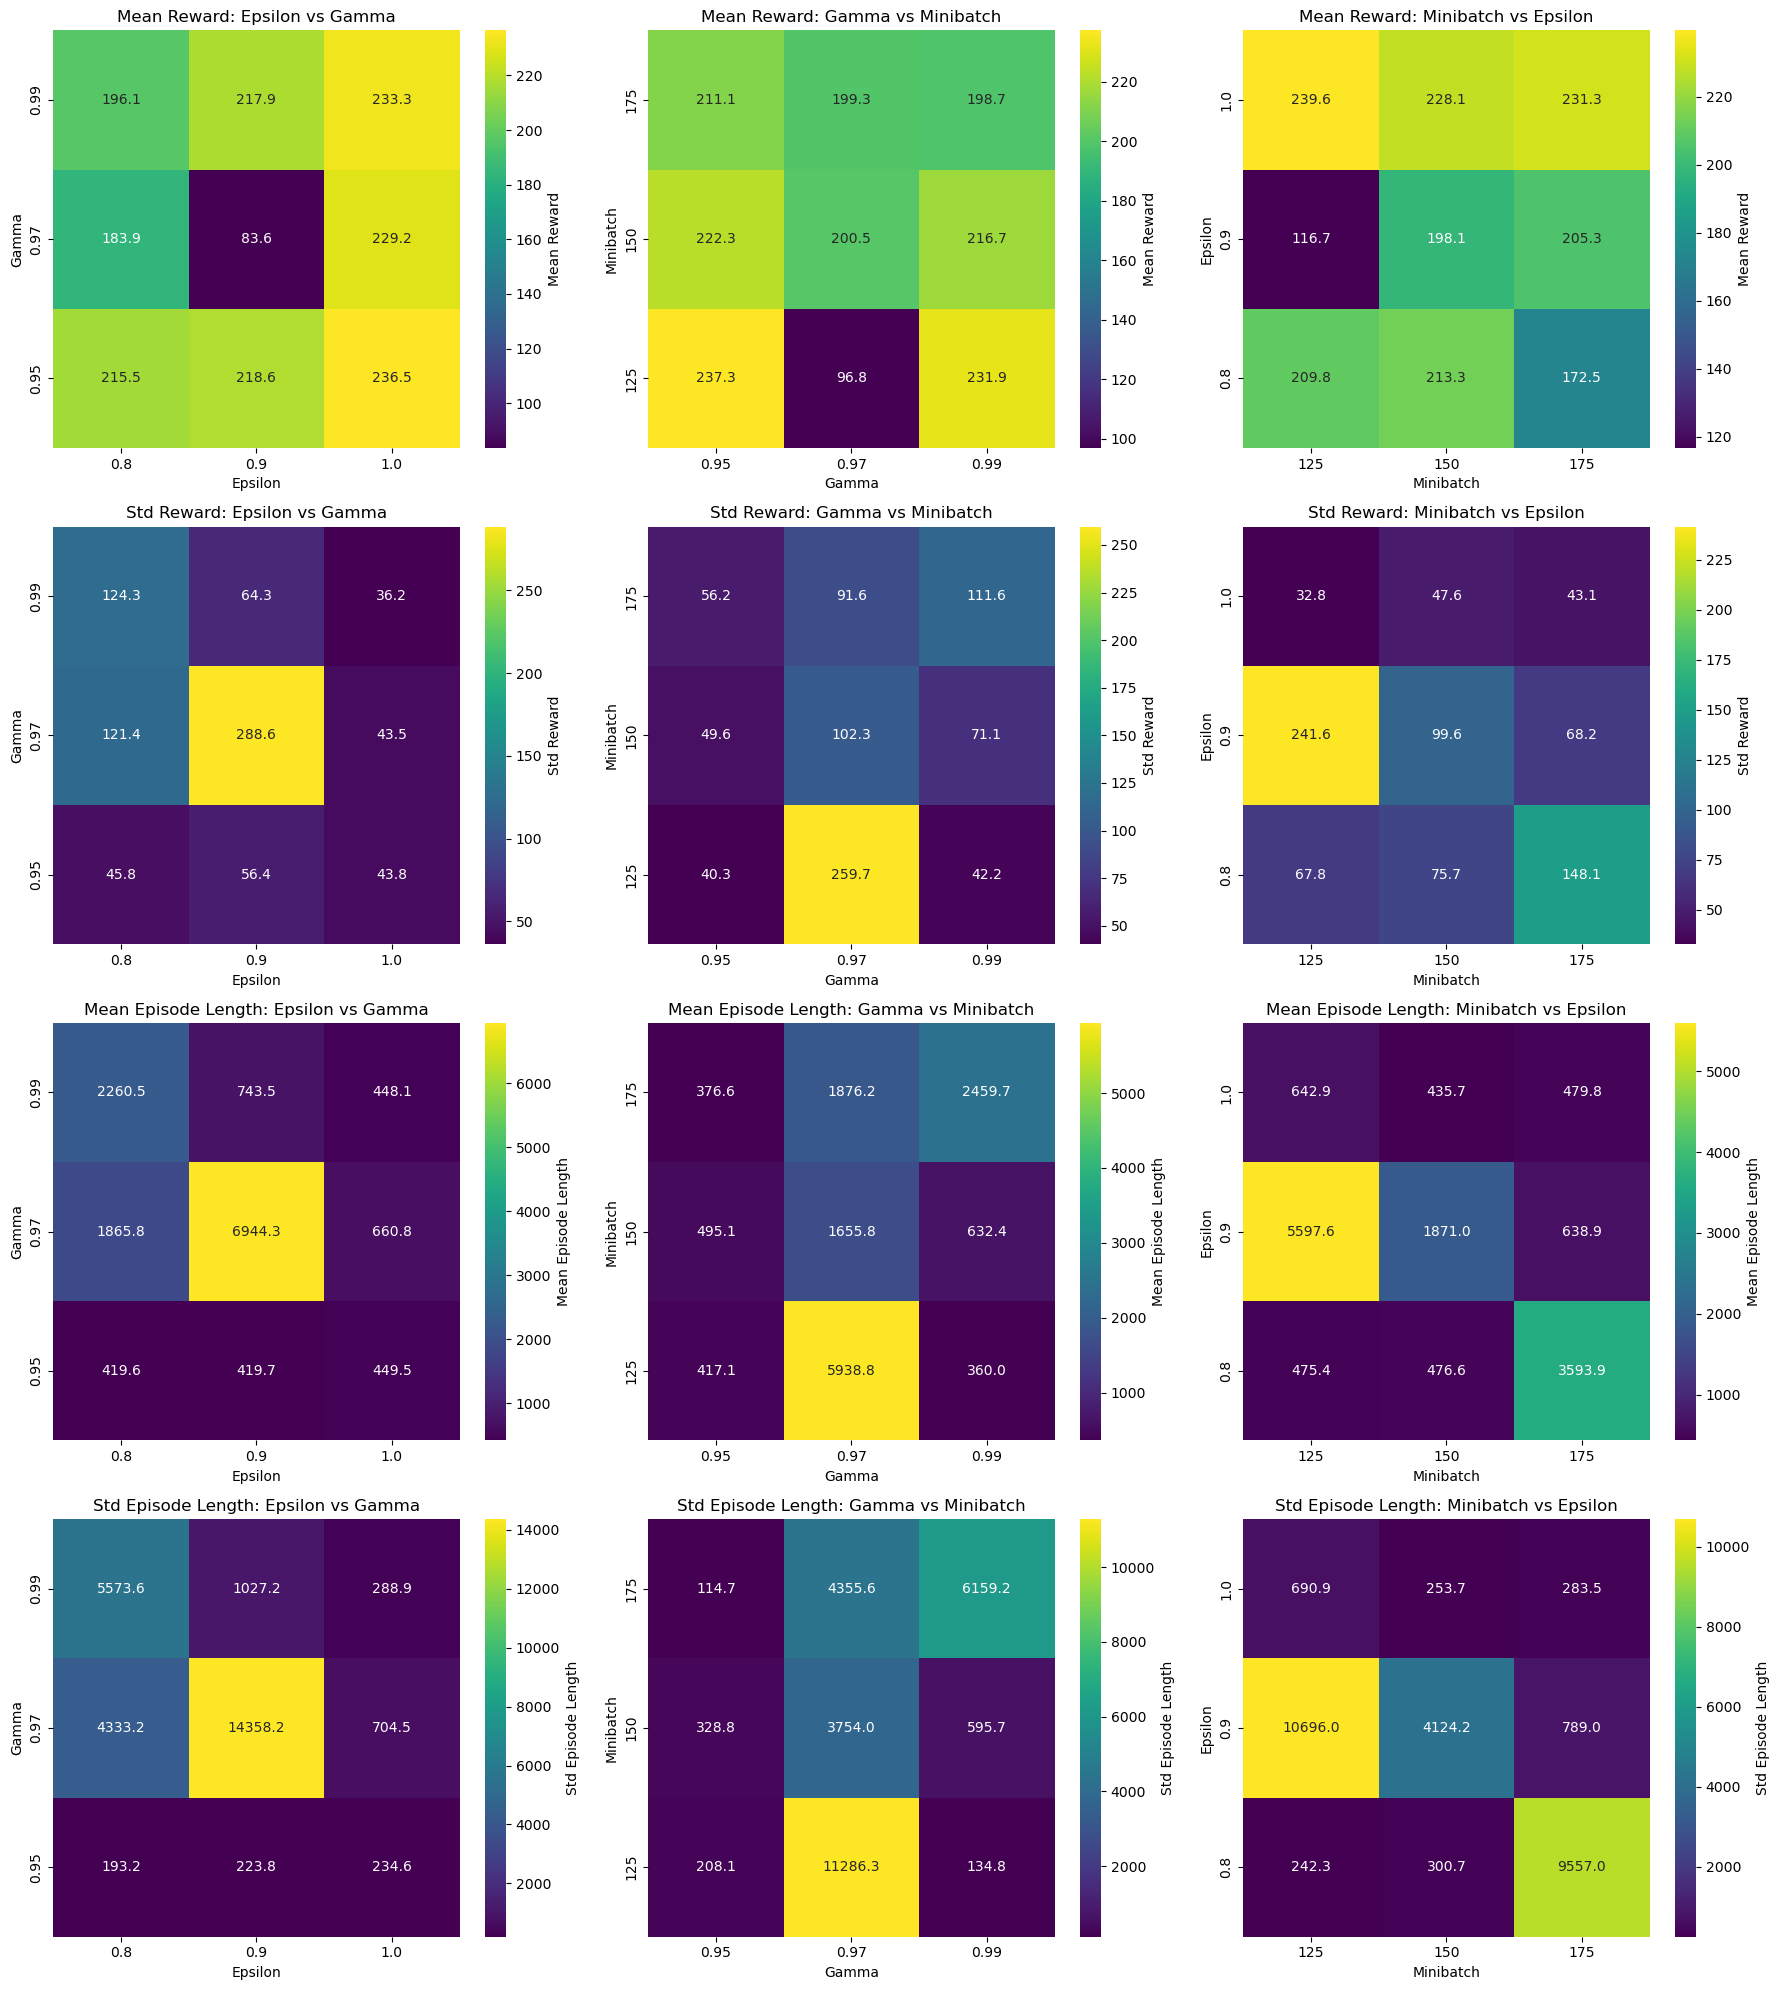

In [ ]:
# directory of the .npy arrays stored
base_dir = "/Users/maartendoekhie/Desktop/lunar_lander/results/sensitivity"

# collecting the results
results = []
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    try:
        # Parse epsilon, gamma, minibatch from folder name
        match = re.match(r"epsilon_(\d+\.\d+)__gamma_(\d+\.\d+)__batch_(\d+)", folder)
        if not match:
            continue
        epsilon, gamma, batch = float(match.group(1)), float(match.group(2)), int(match.group(3))
        
        # Load arrays
        rewards = np.load(os.path.join(folder_path, "eval_rewards.npy"))
        lengths = np.load(os.path.join(folder_path, "eval_lengths.npy"))
        
        # Compute statistics
        mean_reward = np.nanmean(rewards)
        std_reward = np.nanstd(rewards)
        mean_length = np.nanmean(lengths)
        std_length = np.nanstd(lengths)
        
        # Append to results
        results.append({
            "epsilon": epsilon,
            "gamma": gamma,
            "minibatch": batch,
            "mean_reward": mean_reward,
            "std_reward": std_reward,
            "mean_length": mean_length,
            "std_length": std_length
        })
    except Exception as e:
        print(f"Skipping {folder} due to error: {e}")

# dataframe for analysis
df = pd.DataFrame(results)

# sorting
eps_values = sorted(df["epsilon"].unique())
gamma_values = sorted(df["gamma"].unique())
batch_values = sorted(df["minibatch"].unique())

# metrics and pairing the values for plotting
metrics = [
    ("mean_reward", "Mean Reward"),
    ("std_reward", "Std Reward"),
    ("mean_length", "Mean Episode Length"),
    ("std_length", "Std Episode Length"),
]

param_pairs = [
    ("epsilon", "gamma", "Epsilon vs Gamma", eps_values, gamma_values),
    ("gamma", "minibatch", "Gamma vs Minibatch", gamma_values, batch_values),
    ("minibatch", "epsilon", "Minibatch vs Epsilon", batch_values, eps_values),
]

# figures and subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for row, (metric_col, metric_label) in enumerate(metrics):
    for col, (x_param, y_param, title_suffix, x_vals, y_vals) in enumerate(param_pairs):
        ax = axes[row, col]
        
        # Pivot table
        pivot = df.pivot_table(index=y_param, columns=x_param, values=metric_col, aggfunc=np.mean)
        
        # Ensure ascending order
        pivot = pivot.reindex(index=y_vals, columns=x_vals)
        
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis",
                    cbar_kws={'label': metric_label}, ax=ax, mask=pivot.isna())
        
        # Fix orientation so origin is bottom-left
        ax.invert_yaxis()
        
        # Tick positions and labels from your variations
        ax.set_xticks(np.arange(len(x_vals)) + 0.5)
        ax.set_xticklabels([str(val) for val in x_vals])
        ax.set_yticks(np.arange(len(y_vals)) + 0.5)
        ax.set_yticklabels([str(val) for val in y_vals])
        
        # Titles and labels
        ax.set_title(f"{metric_label}: {title_suffix}")
        ax.set_xlabel(x_param.title())
        ax.set_ylabel(y_param.title())

plt.tight_layout()
plt.show()
